# *Customer Lifetime Value Prediction Model*
**Notebook by Gaurav Tawri**

### 1. Setup & Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import Markdown, display

### 2. Data Loading & Initial Exploration
**2.1. Data Loading & Initial Exploration**

In [19]:
# Loading the dataset with specified encoding
df = pd.read_csv('C:\\Users\\gaura\\Downloads\\Data Analyst (Elevate Labs)\\Projects\\Project 2\\E-commerce Data.csv', parse_dates=['InvoiceDate'], encoding='ISO-8859-1')

**2.2 Preview Data**

In [20]:
display(df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**2.3 Data Info & Missing Values**

In [21]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


### 3. Data Cleaning & Feature Engineering

**3.1 Droping rows without CustomerID and invalid transactions**

In [22]:
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

**3.2 Computing OrderValue**

In [23]:
df['OrderValue'] = df['Quantity'] * df['UnitPrice']

**3.3 RFM aggregation**

In [24]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'OrderValue': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']
print('### 3.1 RFM Features')
display(rfm.head())

### 3.1 RFM Features


,CustomerID,Recency,Frequency,Monetary,AOV
0,12346.0,326,1,77183.60,77183.600000
1,12347.0,2,7,4310.00,615.714286
2,12348.0,75,4,1797.24,449.310000
3,12349.0,19,1,1757.55,1757.550000
4,12350.0,310,1,334.40,334.400000


### 4. Model Training & Evaluation

**4.1 Model Training & Evaluation**

In [25]:
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Monetary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**4.2 Metrics**

In [26]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'**MAE:** {mae:.2f} | **RMSE:** {rmse:.2f}\n')

**MAE:** 245.43 | **RMSE:** 2365.48



### 5. Save Predictions

**5.1 Save Predictions**

In [27]:
rfm['Predicted_LTV'] = model.predict(X)
rfm.to_csv('Customer_LTV_Predictions.csv', index=False)
print('Saved Customer_LTV_Predictions.csv')

Saved Customer_LTV_Predictions.csv


### 6. Visualizations
**6.1 Visualizations**

1. Distribution of Predicted LTV

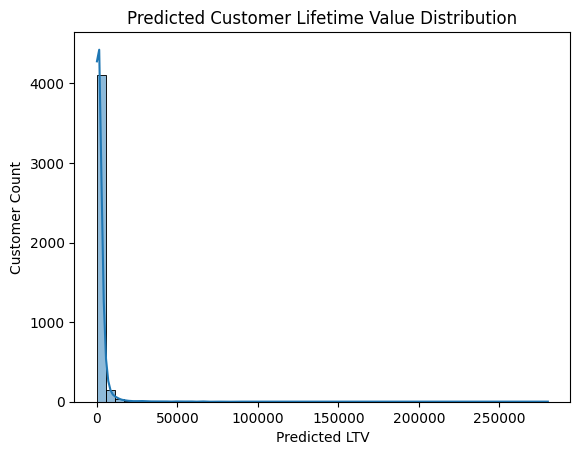

In [28]:
sns.histplot(rfm['Predicted_LTV'], bins=50, kde=True)
plt.title('Predicted Customer Lifetime Value Distribution')
plt.xlabel('Predicted LTV')
plt.ylabel('Customer Count')
plt.show()

2. Top 10 Customers by Predicted LTV

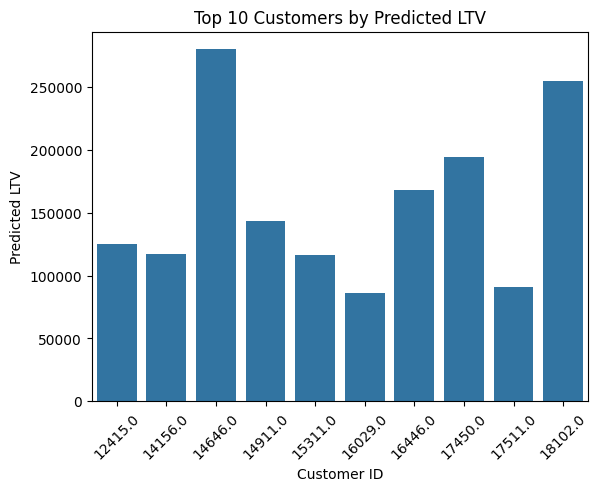

In [29]:
top10 = rfm.nlargest(10, 'Predicted_LTV')
sns.barplot(data=top10, x='CustomerID', y='Predicted_LTV')
plt.title('Top 10 Customers by Predicted LTV')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.ylabel('Predicted LTV')
plt.show()

3. Recency vs Predicted LTV Scatter

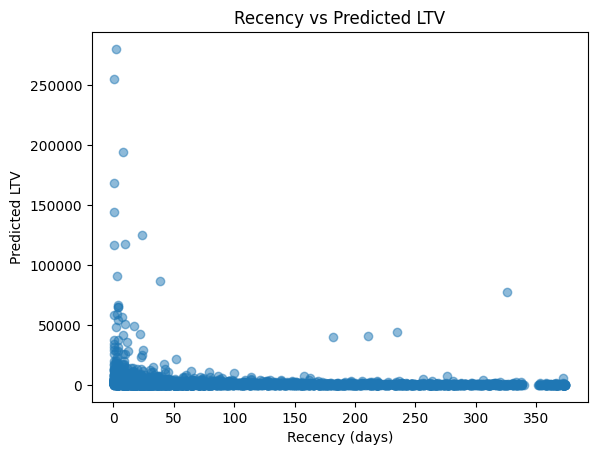

In [30]:
plt.scatter(rfm['Recency'], rfm['Predicted_LTV'], alpha=0.5)
plt.title('Recency vs Predicted LTV')
plt.xlabel('Recency (days)')
plt.ylabel('Predicted LTV')
plt.show()

4. Average LTV by Frequency

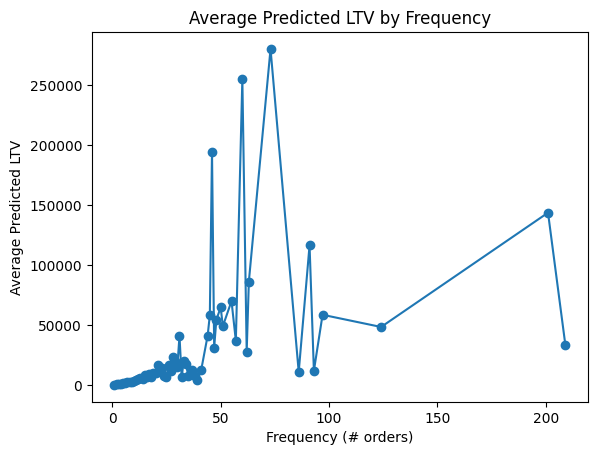

In [31]:
freq_pivot = rfm.groupby('Frequency')['Predicted_LTV'].mean().reset_index()
plt.plot(freq_pivot['Frequency'], freq_pivot['Predicted_LTV'], marker='o')
plt.title('Average Predicted LTV by Frequency')
plt.xlabel('Frequency (# orders)')
plt.ylabel('Average Predicted LTV')
plt.show()

5. Correlation Heatmap

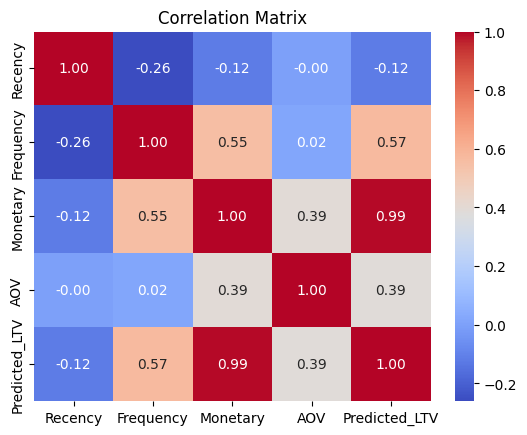

In [32]:
corr = rfm[['Recency', 'Frequency', 'Monetary', 'AOV', 'Predicted_LTV']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

6. Pareto Chart

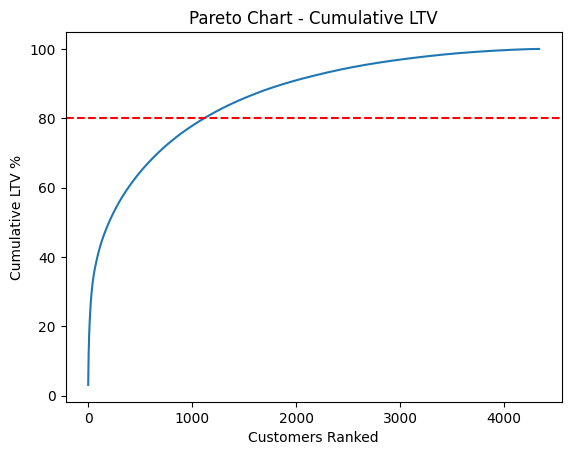

In [33]:
rfm_sorted = rfm.sort_values('Predicted_LTV', ascending=False)
rfm_sorted['CumSum'] = rfm_sorted['Predicted_LTV'].cumsum()
rfm_sorted['CumPerc'] = 100 * rfm_sorted['CumSum'] / rfm_sorted['Predicted_LTV'].sum()
plt.plot(rfm_sorted['CumPerc'].values)
plt.axhline(80, color='red', linestyle='--')
plt.title('Pareto Chart - Cumulative LTV')
plt.xlabel('Customers Ranked')
plt.ylabel('Cumulative LTV %')
plt.show()

### 7. Conclusion

**Conclusion & Next Steps**
1. High-frequency customers drive majority of LTV
2. Negative recency correlates with higher LTV
3. Next: Integrate predictions into BI for segmentation
4. Consider SHAP for model explainability